In [1]:
import mne                                                              # Librería de python para explorar, visualizar,
mne.set_log_level('WARNING')                                            # y analizar datos neurofisiológicos humanos.
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb                                                    
color = ['green', 'blue','red','cyan', 'magenta', 'yellow','k','w']     # Paleta de colores para diferenciar las ondas

import a_funciones as a_fun                                             # Funciones Alex
import os                                                               # Para importar varios archivos

xlabel = 'Muestra'                                                      # Abscisas
ylabel = 'Amplitud (uV)'                                                # Ordenadas

## a_Lag&DrugSignal_v7_case3_gauss.ipynb.
##### En ésta version, se reemplaza el ERPTemplate por una función Gaussiana. El objetivo es mostrar el cambio en el rendimiento frente a una señal *estándar* y poder comparar dicho rendimiento con los obtenidos previamente al *drogar* la señal. se contemplan las dos opciones de insertar una función Gaussiana. Queda en comentario una línea de código en donde se puede multiplicar el ERPTemplate por la función Gaussiana.  
##### *El procesamiento de los EEG se ejecutan en RAM: no se guardan en .csv.*

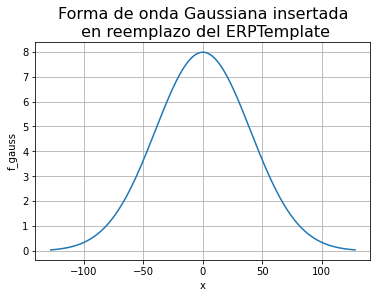

KeyboardInterrupt: 

In [2]:
# Carga y ajuste de la plantilla de un ERP seleccionado previamente.
mat = scipy.io.loadmat('./dataset/ERPTemplate.mat')
routput = mat['routput']
erptemplate1 = routput[0][7][0][1][0][0][0][7]                              # erptemplate2 = routput[0][7][0][1][0][0][0][0] 
erptemplate1 = np.delete( erptemplate1, range(0,256,43),0)                  # erptemplate2 = np.delete( erptemplate2, range(0,256,43),0)

#-------------------------------------
# Observación general del DS ITBA: Pacientes experimento PASIVO -> P300S01,02,03,06. | Pacientes experimento ACTIVO: P300S04, 05, 07 y 08.
# NOTA IMPORTANTE: SI DROGÁS LA SEÑAL ES PORQUE ESTÁS USANDO UNA TRAZA EEG DE PACIENTES EN MODALIDAD PASIVA.
# Es decir, que no se están enfocando en nada particular. Con éstos EEG + ERP se crea el dataset sintético.
#-------------------------------------

# Carga de la señal EEG
punto_mat = scipy.io.loadmat('./dataset/itba/P300S01.mat') 
signal = punto_mat['data'][0][0][0] 

'''
df_signal = a_fun.to_df(signal)
titulo = 'signal original'
#a_fun.grafic_8ch_test(df_signal, titulo, xlabel, ylabel)  
'''

#t_trials = punto_mat['data'][0][0][3]
t_flash = punto_mat['data'][0][0][4] 
#t_stim = mat['data'][0][0][2]
#t_type = mat['data'][0][0][1]

# Vector principal donde se definen los cambios que tendrá la señal principal EEG.
# Caso1: Coeficiente del erptemplate
# lag_flash = [x/5 for x in range(0, 5)] + [x/2 for x in range(1, 31)] # Lista con valores 0 al 1 en intervalos de 0.2 + 1 al 15 en intervalos de 0.5.
# lag_flash = [x/3 for x in range(1, 61)] # Lista con valores del 1 al 30 en intervalos de 0.3.
lag_flash = [x for x in range(1, 257)] # Lista con valores del 1 al 30 en intervalos de 0.3.
# Caso2: Desfase de la señal.

# Parámetros de la función gaussiana
mu = 0      # Media
sigma = 40   # Desviación estándar
amp = 800  # Amplitud
# Generar valores x
# x = np.linspace(-5, 5, 61)
x = np.linspace(-128, 128, 256)
# Calcular los valores de la función gaussiana
f_gauss = amp * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)**2) / (2 * sigma**2))

plt.plot(x, f_gauss)
plt.title('Forma de onda Gaussiana insertada\n en reemplazo del ERPTemplate', fontsize=16)  # Establecer el título con el tamaño de fuente deseado
plt.xlabel('x')
plt.ylabel('f_gauss')
plt.grid()
plt.savefig("./a_images/Gauss.jpg")
plt.show()


# Genero un conjunto de archivos, cada uno de ellos es una variación de la señal ppal EEG desfasada.
meta_P300S01 = np.empty(len(f_gauss), dtype=object)
for j,lag in enumerate(f_gauss):   
    punto_mat = scipy.io.loadmat('./dataset/itba/P300S01.mat') # print(f'Posición del vector lag_flash:{j} | Desfase de {lag} muestras')
    signal = punto_mat['data'][0][0][0] 
    for i in range(0,4200):
        if (t_flash[i,3]==2):
            # signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*3) # Línea original.
            # signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*lag) # -> CASO 4: Multimplicando el ERPTemplate por una función Gaussiana.
            signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (lag) # -> CASO 4: Reemplazando el ERPTemplate por una función Gaussiana.        
    meta_P300S01[j] = signal
    
# Opcional: Grabado en disco y graficado de todos los EEG procesados.
'''
np.savetxt(f'./a_results/meta_P300S02.csv', meta_P300S02, delimiter=',',fmt='%s')
for j, cont_P300S01 in enumerate(meta_P300S01):   
    df = a_fun.to_df(cont_P300S01)
    titulo = (f'P300S01 con un desfase de {lag_flash[j]}')
    a_fun.grafic_8ch_test(df, titulo, xlabel, ylabel)  
'''

In [ ]:
#----------------------------------------------------------------------------------------------------------
#----------Ciclo principal: Carga, preprocesamiento, obtención hits/no hits, testeo y resultados.----------
#----------------------------------------------------------------------------------------------------------
for ii, path in enumerate(meta_P300S01):
#------------------------------------------------------
#----------Etapa 1: Carga y preprocesamiento.----------
#------------------------------------------------------
    results_mne=f'./a_results/Resultados Paciente P300S01_0{ii}.csv' # Se puede cambiar a .txt pero NO disminuye el tamaño del archivo.
    file_temp=open(results_mne,"w") 
    print(f', P300S01_{ii}', file=file_temp) # COLUMNA0.
    punto_mat = scipy.io.loadmat('./dataset/itba/P300S01.mat')
    
    signal = path
    
    t_trials = punto_mat['data'][0][0][3]
    t_flash = punto_mat['data'][0][0][4]
    t_stim = punto_mat['data'][0][0][2]
    t_type = punto_mat['data'][0][0][1]
    
    ch_names=[ 'Fz'  ,  'Cz',    'P3' ,   'Pz'  ,  'P4'  ,  'PO7'   , 'PO8'   , 'Oz']
    ch_types= ['eeg'] * signal.shape[1]
    ch_names_events = ch_names + ['t_stim']+ ['t_type']
    ch_types_events = ch_types + ['misc'] + ['misc']
    
    #info = mne.create_info(ch_names, 250, ch_types=ch_types)
    #eeg_mne = mne.io.array.RawArray(signal.T, info)
    signal_events = np.concatenate([signal, t_stim, t_type],1)
    info_events = mne.create_info(ch_names_events,250, ch_types_events)
    eeg = mne.io.RawArray(signal_events.T, info_events)
    
    #fig=eeg.plot_psd()
    eeg.filter(1,20)
    #fig=eeg.plot_psd()
    event_times = mne.find_events(eeg, stim_channel='t_type') 
    #eeg.plot(scalings='auto',n_channels=8,events=event_times,block=True)   # scalings=10e-05
    
    if (np.unique(t_flash[:,0]).shape[0] != 4200):                          # evalúa si el "sample point id" de t_flash tiene el tamaño correcto.
        u,c = np.unique( t_flash[:,0], return_counts=True)                  # u->Los elementos únicos. c->la cantidad de veces que se repiten.
        dup = u[c>1]                                                        # dup->Los que estén repetidos mas de una vez.    
        
        for i in range(dup.shape[0]):
            idx = np.where( t_flash[:,0] == dup[i] )[0][0]
            t_flash[idx,0]  -= 1
            t_flash[idx,1]  = 1
            t_type[t_flash[idx,0]] = t_flash[idx,3]
            t_stim[t_flash[idx,0]] = t_flash[idx,2]

    np.unique(t_flash[:,0]).shape
    assert  np.unique(t_flash[:,0]).shape[0] == 4200, 'Problem with experiment structure.  There aren''t enough events.'
#--------------------------------------------------
#----------Etapa 2: Obtener hits/no hits.----------
#--------------------------------------------------
    def getstims(eeg_mne, eeg_events):                                      # Get the stimulations.  These are the FLASHINGS of rows and columns.
        tmin = 0 
        tmax = 0.8
        reject = None
        event_times = mne.find_events(eeg_events, stim_channel='t_stim',shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
                        
        event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}

        epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                        baseline=None, reject=reject, preload=True,
                        verbose=True, reject_by_annotation=None)
        
        stims = event_times[:,-1]
        return [epochs,stims]
    stimepochs, stims = getstims(eeg, eeg)
    
    def getlabels(eeg_mne, eeg_events, event_id):
        print(f'\n-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-')
        tmin = 0
        tmax = 0.8
        reject = None
        event_times = mne.find_events(eeg_events, stim_channel='t_type', shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
        epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                        baseline=None, reject=reject, preload=True,
                        verbose=True, reject_by_annotation=None)
        labels = epochs.events[:, -1]
        return [epochs, labels]
    
    # Tupla de tres valores: epochs.get_data().shape . Tomo uno por uno
    # epocked: Objeto de tipo <class 'mne.evoked.EvokedArray'>. 
    # En epocked.data puedo sacar info pero por ahora no hay nada. 
    # El profesor lo usa para visualizar: evoked.plot(). De acá se pueden sacar segmentos promedio.
    epochs, labels = getlabels(eeg, eeg, {'first':1}) # -> {'first':1}: Nohits.
    epocked = epochs.average()
    
    epochs, labels = getlabels(eeg, eeg, {'second':2}) # -> {'second':2}: Hits.
    epocked = epochs.average()
        
    epochs, labels = getlabels(eeg, eeg, { 'first':1, 'second':2})          # OJO CON ESTA LÍNEA: JUNTA LOS HITs/NO HITs
    
    # Downsample the original FS=250 Hz signal to >>> 20 Hz | epochs.resample(20, npad="auto") | stimepochs.resample(20, npad="auto")
    repetitions=120
#----------------------------------------------------------------------------------
#----------Etapa 3: Testeo de los cambios: modelo de regresión logística.----------
#----------------------------------------------------------------------------------
    # This is Single Flashing Classification attempt.
    from sklearn.preprocessing import  StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn import svm
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score # support
    from sklearn.preprocessing import MinMaxScaler

    from mne.decoding import LinearModel                                    # import a linear classifier from mne.decoding
    import matplotlib.pyplot as plt
    clf = LogisticRegression(solver='lbfgs')
    scaler = StandardScaler()

    model = LinearModel(clf)                                                # create a linear model with LogisticRegression

    # Get the epoched data (get only the data columns)
    eeg_data2 = epochs.get_data() # eeg_data2.shape -> (4004, 10, 201): 4004 events found, 201 time points and 10 channels
    eeg_data = epochs.get_data().reshape(len(labels), -1) # Obtener epochs, reorganiza en arreglo con las etiquetas "labels".
    eeg_data3 = eeg_data
    eeg_data = eeg_data[:,0:epochs.get_data().shape[2]*1] # Selección de todas las filas y recorte de matriz: dos primeras columnas.
    #eeg_data[labels==2] = erptemplate1[:201,0]
    #eeg_data[labels==1] = erptemplate1[:201,0]

    #eeg_data[labels==2] = np.zeros((eeg_data.shape[1],))
    #eeg_data[labels==1] = np.ones((eeg_data.shape[1],))
    #labels = np.random.permutation(labels)

    X = scaler.fit_transform(eeg_data) # Ajuste del clasificador. Estandarizar los datos: media de cero y una desviación estándar de uno. X.shape = (4004, 201)

    model.fit(X[0:2800], labels[0:2800]) # Entrenamiento con los primeros 2800 elementos de X y las etiquetas "labels".

    preds = model.predict(X[2800:]) # Predicción con el resto de los 2800 elementos.
#------------------------------------------------------
#----------Etapa 4: Generación de resultados.----------
#------------------------------------------------------
    target_names = ['nohit', 'hit']
    report = classification_report(labels[2800:], preds, target_names=target_names)
    report_dict = classification_report(labels[2800:], preds, target_names=target_names, output_dict=True)
    
    print(f'Muestra, {int(ii+1)}', file=file_temp)
    print(f'Coef_erp, {lag_flash[ii]}', file=file_temp)

    nohit_precision = report_dict['nohit']['precision']
    nohit_recall = report_dict['nohit']['recall']
    nohit_f1_score = report_dict['nohit']['f1-score']
    nohit_support = report_dict['nohit']['support']
    print(f'nohit_precision, {nohit_precision}', file=file_temp)
    print(f'nohit_recall, {nohit_recall}', file=file_temp)
    print(f'nohit_f1_score, {nohit_f1_score}', file=file_temp)
    print(f'nohit_support, {nohit_support}', file=file_temp)

    hit_precision = report_dict['hit']['precision']
    hit_recall = report_dict['hit']['recall']
    hit_f1_score = report_dict['hit']['f1-score']
    hit_support = report_dict['hit']['support']
    print(f'hit_precision, {hit_precision}', file=file_temp)
    print(f'hit_recall, {hit_recall}', file=file_temp)
    print(f'hit_f1_score, {hit_f1_score}', file=file_temp)
    print(f'hit_support, {hit_support}', file=file_temp)

    '''
    cm = confusion_matrix(labels[2800:], preds)
    print (cm)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))
    '''    
    
    file_temp.close()
#-----------------------------------------
#---------- FIN Ciclo principal.----------
#-----------------------------------------
    

In [ ]:
#-------------------------------------------------------------
#---------- Presentación de resultados en una tabla.----------
#-------------------------------------------------------------
path2 = './a_results/'
columns_list = []

for filename in os.listdir(path2):
    if filename.startswith('Resultados Paciente') and filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(path2, filename), delimiter=',')
        columns_list.append(df.iloc[:, 1])

resultados = pd.concat(columns_list, axis=1)
resultados.columns = [filename[:-4] for filename in os.listdir(path2) if filename.startswith('Resultados Paciente') and filename.endswith('.csv')]
df1 = pd.read_csv('./a_results/Resultados Paciente P300S01_00.csv', index_col=0)
resultados.set_index(df1.index, inplace=True)
resultados.to_csv('./a_results/resultados_caso4.csv', index=False)
resultados = resultados.T
resultados = resultados.sort_values(by=['Muestra'],ascending=[True])
resultados['Muestra'] = resultados['Muestra'].astype(int)
#resultados['Indice'] = resultados['Muestra']-1
#resultados['Experimento'] = resultados.index
#resultados['Muestra'] = resultados['Muestra']-1
#df_resultados = a_fun.to_df(resultados)
resultados

In [ ]:
#------------------------------------------
#---------- Presentación gráfica.----------
#------------------------------------------
plt.figure(figsize=(30,8))                                          
axes = plt.gca()                                                    
plt.plot(resultados['Coef_erp'], resultados['hit_precision'], '-o', label='hits') 
plt.plot(resultados['Coef_erp'], resultados['nohit_precision'], '-o',label='no hits') 
#axes.set_title('Precision')
axes.set_xlabel('Coef_erp (µV)')
axes.set_ylabel('Precision')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)                                  
plt.grid()
plt.legend(loc='center',fontsize='xx-large')
plt.savefig("./a_images/resultados_caso4_a_precision.jpg")
plt.show()
#------------------------------------------
plt.figure(figsize=(30,8))                                          
axes = plt.gca()                                                    
plt.plot(resultados['Coef_erp'], resultados['hit_recall'], '-o', label='hits') 
plt.plot(resultados['Coef_erp'], resultados['nohit_recall'], '-o',label='no hits') 
#axes.set_title('Precision')
axes.set_xlabel('Coef_erp (µV)')
axes.set_ylabel('Recall')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)                                  
plt.grid()
plt.legend(loc='center',fontsize='xx-large')
plt.savefig("./a_images/resultados_caso4_b_recall.jpg")
plt.show()
#------------------------------------------
plt.figure(figsize=(30,8))                                          
axes = plt.gca()                                                    
plt.plot(resultados['Coef_erp'], resultados['hit_f1_score'], '-o', label='hits') 
plt.plot(resultados['Coef_erp'], resultados['nohit_f1_score'], '-o',label='no hits') 
#axes.set_title('Precision')
axes.set_xlabel('Coef_erp (µV)')
axes.set_ylabel('f1_score')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)                                  
plt.grid()
plt.legend(loc='center',fontsize='xx-large')
plt.savefig("./a_images/resultados_caso4_c_f1_score.jpg")
plt.show()
#------------------------------------------
plt.figure(figsize=(30,8))                                          
axes = plt.gca()                                                    
plt.plot(resultados['Coef_erp'], resultados['hit_support'], '-o', label='hits') 
plt.plot(resultados['Coef_erp'], resultados['nohit_support'], '-o',label='no hits') 
#axes.set_title('Precision')
axes.set_xlabel('Coef_erp (µV)')
axes.set_ylabel('Support')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)                                  
plt.grid()
plt.legend(loc='center',fontsize='xx-large')
plt.savefig("./a_images/resultados_caso4_d_support.jpg")
plt.show()
#------------------------------------------

# =======================================
# Por ahora hasta acá
# =======================================



Acá puedo revisar esta guia -> [*Guía*](https://github.com/faturita/python-nerv/blob/master/MNE%20BNCI%20Horizon%202020%20Dataset%20008-2014.ipynb)    



### Análisis de DrugSignal.py, parte II  
  
En *a_analisis_funcion_DrugSignal.ipynb* se llega a drogar la señal con variaciones en la amplitud y fase.  
A continuación la preparación de los datos para ser visualizados con la librería de python mne.  
  
[*Creating data objects from arrays. mne library*](https://mne.tools/stable/creating_from_arrays.html)  
  
- Una instancia básica de información llamada *info_events*:  
Esta contiene el nombre de los canales, el ratio de muestreo y el canal de datos.  
Para éste caso no se usará canal de datos, por eso se carga *ch_types_events* con ['misc'].  
  
- Un objeto "en crudo" a partir de un array de numpy llamado *eeg*.  

- Un tercer objeto *event_times* que trae la info completa y además agrega el 't_type',
profundizado en [*a_analisis_p300subject25_stim&type.ipynb*](a_analisis_p300subject25_stim&type.ipynb).

Al finalizar, tendremos un objeto *eeg* que contiene todo:  
La señal drogada, *t_stim* y *t_type* y sus respectivos eventos.

In [ ]:
ch_names=['Fz','Cz','P3','Pz','P4','PO7','PO8', 'Oz']                   # Los nombres de los canales
ch_types= ['eeg'] * signal.shape[1]                                     # Un vector de tamaño 8 con el'eeg' repetido
ch_names_events = ch_names + ['t_stim']+ ['t_type']                     # Le agrega  't_stim' y't_type' 
ch_types_events = ch_types + ['misc'] + ['misc']                        # Le agrega dos 'misc': 
                                                                        # Channel types, default is 'misc' which is not a data channel. 
                                                                        # Currently supported fields are ‘ecg’, ‘bio’, ‘stim’, ‘eog’, ‘misc’, 
                                                                        # ‘seeg’, ‘dbs’, ‘ecog’, ‘mag’, ‘eeg’, ‘ref_meg’, ‘grad’, ‘emg’, ‘hbr’ or ‘hbo’. 
                                                                        # If str, then all channels are assumed to be of the same type.
#info = mne.create_info(ch_names, 250, ch_types=ch_types)
#eeg_mne = mne.io.array.RawArray(signal.T, info)

signal_events = np.concatenate([signal, t_stim, t_type],1)              # Se agrega a la señal drogada 't_stim' y 't_type'

df_signal_events = a_fun.to_df(signal_events)
ch_names_events_with_sample = ch_names_events + ['sample']
df_signal_events.columns = ch_names_events_with_sample

info_events = mne.create_info(ch_names_events,250, ch_types_events)     # Acá crea los eventos. 
eeg = mne.io.RawArray(signal_events.T, info_events)                     # El objeto en crudo.

# Do some basic signal processing (1-20 band pass filter)
# *** fig=eeg.plot_psd()
eeg.filter(1,20)
# *** fig=eeg.plot_psd()
event_times = mne.find_events(eeg, stim_channel='t_type')    
# *** eeg.plot(scalings='auto',n_channels=8,events=event_times,block=True)   # scalings=10e-05

#========================================================================
# ChatGPT:
# Primero, verifica si la cantidad de valores únicos en la primera columna de la matriz es igual a 4200. 
# Si no es así, entonces el código busca valores duplicados en la primera columna de la matriz 
# y disminuye el valor de la fila correspondiente en 1 y establece el valor de la columna 1 en 1. 
# Luego, establece los valores de las columnas 2 y 3 de la matriz t_type y t_stim según los valores
# correspondientes de la columna 3 y 2 de la matriz t_flash.
# En la última línea del código, se utiliza la función assert para asegurarse de que la cantidad de valores únicos en la primera columna de la matriz t_flash sea igual a 4200. Si no lo es, se imprimirá un mensaje de error indicando que hay un problema con la estructura del experimento.

if (np.unique(t_flash[:,0]).shape[0] != 4200):                          # evalúa si el "sample point id" de t_flash tiene el tamaño correcto.
    u,c = np.unique( t_flash[:,0], return_counts=True)                  # u->Los elementos únicos. c->la cantidad de veces que se repiten.
    dup = u[c>1]                                                        # dup->Los que estén repetidos mas de una vez.    
    
    for i in range(dup.shape[0]):
        idx = np.where( t_flash[:,0] == dup[i] )[0][0]
        t_flash[idx,0]  -= 1
        t_flash[idx,1]  = 1
        t_type[t_flash[idx,0]] = t_flash[idx,3]
        t_stim[t_flash[idx,0]] = t_flash[idx,2]

np.unique(t_flash[:,0]).shape
assert  np.unique(t_flash[:,0]).shape[0] == 4200, 'Problem with experiment structure.  There aren''t enough events.'

Gráficas de la señal con el ERP agregado y con *t_stim y t_type*.   
La primera gráfica muestra el resultado general.    
La segunda gráfica es cada una de las señales en un periodo de tiempo determinado.  

In [ ]:
#plt.figure(figsize=(30,8))                                     
#axes = plt.gca()
#for i in range(0,9):
#    plt.plot(df_signal_events['sample'], df_signal_events.iloc[:,i])
#axes.set_title('DrugSignal con t_stim y t_type'), axes.title.set_size(30)
#axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
#axes.xaxis.label.set_size(20), axes.yaxis.label.set_size(20)
#plt.savefig("./a_images/DrugSignal_p300subject25[data][0][0][0].jpg")
#plt.grid(), plt.show()
                 

xlim_general=([7000,15500])
ylim_general=([-50,80])
eje_x_sample=df_signal_events['sample']
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=10, ncols=1,figsize=(30,20))
fig.suptitle("DrugSignal con t_stim y t_type  \n Eje x: muestra. Eje y: uV ", fontsize=30)

ax0.plot(eje_x_sample, df_signal_events.iloc[:,0], label='0') 
ax0.set_xlim(xlim_general), ax0.set_ylim(ylim_general), ax0.set_title(df_signal_events.columns[0]), ax0.grid()

ax1.plot(eje_x_sample, df_signal_events.iloc[:,1], label='1')
ax1.set_xlim(xlim_general), ax1.set_ylim(ylim_general), ax1.set_title(df_signal_events.columns[1]), ax1.grid()

ax2.plot(eje_x_sample, df_signal_events.iloc[:,2], label='2')
ax2.set_xlim(xlim_general), ax2.set_ylim(ylim_general), ax2.set_title(df_signal_events.columns[2]), ax2.grid()

ax3.plot(eje_x_sample, df_signal_events.iloc[:,3], label='3')
ax3.set_xlim(xlim_general), ax3.set_ylim(ylim_general), ax3.set_title(df_signal_events.columns[3]), ax3.grid()

ax4.plot(eje_x_sample, df_signal_events.iloc[:,4], label='4')
ax4.set_xlim(xlim_general), ax4.set_ylim(ylim_general), ax4.set_title(df_signal_events.columns[4]), ax4.grid()

ax5.plot(eje_x_sample, df_signal_events.iloc[:,5], label='5')
ax5.set_xlim(xlim_general), ax5.set_ylim(ylim_general), ax4.set_title(df_signal_events.columns[5]), ax5.grid()

ax6.plot(eje_x_sample, df_signal_events.iloc[:,6], label='6')
ax6.set_xlim(xlim_general), ax6.set_ylim(ylim_general), ax6.set_title(df_signal_events.columns[6]), ax6.grid()

ax7.plot(eje_x_sample, df_signal_events.iloc[:,7], label='7')
ax7.set_xlim(xlim_general), ax7.set_ylim(ylim_general), ax7.set_title(df_signal_events.columns[7]), ax7.grid()

ax8.plot(eje_x_sample, df_signal_events.iloc[:,8], label='8')
ax8.set_xlim(xlim_general), ax8.set_ylim([-3,14]), ax8.set_title(df_signal_events.columns[8]), ax8.grid()

ax9.plot(eje_x_sample, df_signal_events.iloc[:,9], label='9')
ax9.set_xlim(xlim_general), ax9.set_ylim([-0.2,2.2]), ax9.set_title(df_signal_events.columns[9]), ax9.grid()

plt.show()

### Funciones para obtener las estimulaciones y etiquetas.
  
#### getstims.  
La función usa *info*, que es creada con los nombres de los canales (ch_names), la frecuencia de muestreo (259) y los tipos de canales ch_types.  También toma como entrada *eeg_mne*; es la traspuesta de signal e info.

El resultado *event_times* es llamando a la función *find_events* de mne, que encuentra eventos del archivo "raw".  

[*"Find events"*](https://mne.tools/stable/generated/mne.find_events.html)  


[*"Épocas: INVESTIGAR. NO ENTENDI NADA"*](https://mne.tools/stable/generated/mne.Epochs.html#mne-epochs)

#### getlabels.

- Una instancia básica de información llamada *info_events*:  
Esta contiene el nombre de los canales, el ratio de muestreo y el canal de datos.  
Para éste caso no se usará canal de datos, por eso se carga *ch_types_events* con ['misc'].  
  
- Un objeto "en crudo" a partir de un array de numpy llamado *eeg*.  

- Un tercer objeto *event_times* que trae la info completa y además agrega el 't_type',
profundizado en [*a_analisis_p300subject25_stim&type.ipynb*](a_analisis_p300subject25_stim&type.ipynb).

In [ ]:
#========================================================================
# getstims recibe dos argumentos: eeg_mne y eeg_events. eeg_mne debe ser un objeto de tipo MNE Raw o Epochs, 
# mientras que eeg_events debe ser un objeto que contenga los eventos relacionados con la señal EEG.
# La función utiliza la biblioteca MNE de Python para encontrar los eventos en la señal EEG y crear epochs de 0 a 0.8 segundos de duración, 
# a partir de los eventos encontrados. Luego, la función extrae las marcas de tiempo de los eventos y las devuelve como una lista junto 
# con los epochs.

# En resumen, la función getstims extrae los estímulos de una señal EEG y devuelve una lista de epochs y las marcas de tiempo de los eventos 
# relacionados con la señal.

def getstims(eeg_mne, eeg_events):
    '''
    Get the stimulations.  These are the FLASHINGS of rows and columns.
    '''
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_stim',shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}


    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)


    stims = event_times[:,-1]

    return [epochs,stims]

stimepochs, stims = getstims(eeg, eeg)                                  # Época de estimulación.
stimepochs

In [ ]:
#========================================================================
# ChatGPT:
# La función getlabels recibe tres argumentos: eeg_mne, eeg_events y event_id. eeg_mne debe ser un objeto de tipo MNE Raw o Epochs, 
# mientras que eeg_events debe ser un objeto que contenga los eventos relacionados con la señal EEG.
# La función utiliza la biblioteca MNE de Python para encontrar los eventos en la señal EEG y crear epochs de 0 a 0.8 segundos de duración, 
# a partir de los eventos encontrados. Luego, la función extrae las marcas de tiempo de los eventos y las devuelve como una lista junto 
# con los epochs.

# En resumen, la función getstims extrae los estímulos de una señal EEG y devuelve una lista de epochs y las marcas de tiempo de los eventos 
# relacionados con la señal.


def getlabels(eeg_mne, eeg_events, event_id):
    '''
    Get the hit/no hits labels.  These are the FLASHINGS of rows and columns but selected if they are the ones that will
    trigger the P300 response or not.
    '''
    #event_id = { 'first':1, 'second':2 }
    #baseline = (0.0, 0.2)
    #reject = {'eeg': 70 * pow(10,6)}
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_type', shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)
    labels = epochs.events[:, -1]
    return [epochs, labels]

epochs, labels = getlabels(eeg, eeg, {'first':1})


In [ ]:

epocked = epochs.average()
epocked.plot(window_title='NoHit Averaged Signals')


epochs, labels = getlabels(eeg, eeg, {'second':2})

epocked = epochs.average()
epocked.plot(window_title='Hit Averaged Signals')

epochs, labels = getlabels(eeg, eeg, { 'first':1, 'second':2})


# Downsample the original FS=250 Hz signal to >>> 20 Hz
#epochs.resample(20, npad="auto")
#stimepochs.resample(20, npad="auto")
repetitions=120